In [1]:
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('bmh')

# WirVsVirus Hackathon

Die entscheidende Frage bei der Beurteilung aller Maßnahmen ist, ob das exponentielle Wachstum verlangsamt worden ist, d.h. die exponentielle Wachstumskurve abflacht.
Dazu macht man am besten anhand bestehender Daten ein Modell-Fit und schaut, ob aktuelle Fallzahlen das Modell überschreiten oder man mit den Fallzahlen darunter bleibt.

## Download Data from CSSE COVID-19 Dataset

We are using the Covid-19 Dataset: https://github.com/CSSEGISandData/COVID-19

In [2]:
url = 'https://raw.githubusercontent.com'
url += '/CSSEGISandData/COVID-19'
url += '/master/csse_covid_19_data/csse_covid_19_time_series'
url += '/time_series_19-covid-Deaths.csv'

In [3]:
deaths = pd.read_csv(url)

In [4]:
deaths.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20
0,NaN,Thailand,15.0000,101.0000,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
1,NaN,Japan,36.0000,138.0000,0,0,0,0,0,0,...,15,16,19,22,22,27,29,29,29,33
2,NaN,Singapore,1.2833,103.8333,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NaN,Nepal,28.1667,84.2500,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NaN,Malaysia,2.5000,112.5000,0,0,0,0,0,0,...,0,0,0,0,0,0,2,2,2,3


### Preprocessing

In [5]:
ger_deaths = deaths[deaths['Country/Region']=='Germany'].T
ger_deaths = ger_deaths[4:].astype('int')
ger_deaths.columns = ['deaths']

In [6]:
ger_deaths.index = pd.to_datetime(ger_deaths.index)
ger_deaths = ger_deaths.asfreq('D')

In [7]:
ger_deaths = ger_deaths[ger_deaths.deaths>0]

In [8]:
today = ger_deaths.index[-1]

## Feature

In [9]:
ger_deaths['days'] = (ger_deaths.index - ger_deaths.index.min()).days

In [10]:
ger_deaths.head()

,deaths,days
2020-03-09,2,0
2020-03-10,2,1
2020-03-11,3,2
2020-03-12,3,3
2020-03-13,7,4


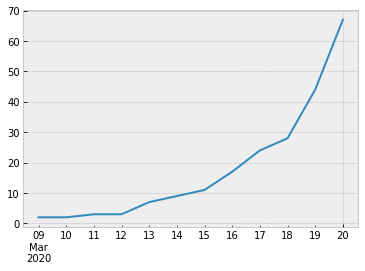

In [11]:
ger_deaths.deaths.plot();

## Prediction Model

In [12]:
from sklearn.linear_model import LinearRegression
import numpy as np

In [13]:
X = ger_deaths['days'].values.reshape(-1, 1)
y = ger_deaths['deaths'].values
logy = np.log(y)

### Train

In [14]:
clf = LinearRegression()
clf.fit(X, logy)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [15]:
logy_pred = clf.predict(X)
ger_deaths['predicted'] = np.exp(logy_pred).astype('int')

In [16]:
ger_deaths.tail()

,deaths,days,predicted
2020-03-16,17,7,16
2020-03-17,24,8,22
2020-03-18,28,9,31
2020-03-19,44,10,44
2020-03-20,67,11,61


## Future

In [17]:
fd = 13 # days into the future

In [18]:
# Create DataFrame in the Future
dates = pd.date_range(ger_deaths.index[-1], periods=fd, closed='right')
days_in_future = ger_deaths.days[-1] + np.arange(1, fd)

future = pd.DataFrame(data=days_in_future, index=dates, columns=['days'])

In [19]:
ger_future = ger_deaths.append(future, sort=True)

### Predict the Future

In [20]:
X_future = ger_future['days'].values.reshape(-1, 1)

In [21]:
logy_pred = clf.predict(X_future)
ger_future['predicted'] = np.exp(logy_pred).astype('int')

In [26]:
ger_future

,days,deaths,predicted
2020-03-09,0,2.0,1
2020-03-10,1,2.0,2
2020-03-11,2,3.0,3
2020-03-12,3,3.0,4
2020-03-13,4,7.0,5
2020-03-14,5,9.0,8
2020-03-15,6,11.0,11
2020-03-16,7,17.0,16
2020-03-17,8,24.0,22
2020-03-18,9,28.0,31


## Future Plot

In [22]:
title = 'Todesfälle und Vorhersage für Deutschland (Basierend auf CSSE COVID-19 Dataset)'

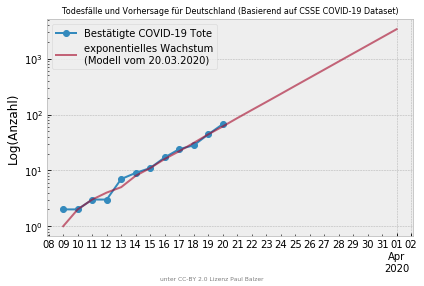

In [25]:
ax = ger_future['deaths'].plot(label='Bestätigte COVID-19 Tote', marker='o')
ax = ger_future['predicted'].plot(label='exponentielles Wachstum\n(Modell vom %s)' % today.strftime('%d.%m.%Y'),
                                  alpha=0.6, ax=ax)

ax.legend()
ax.set_ylabel('Log(Anzahl)')
ax.set_yscale('log')
ax.set_title(title, fontsize=8)
ax.annotate('unter CC-BY 2.0 Lizenz Paul Balzer', xy=(.5, 0.02), xycoords='figure fraction', ha='center', fontsize=6, color='gray')

plt.tight_layout()
plt.savefig('./%s-Germany-Covid19-Death-Prediction.png' % today.strftime('%Y-%m-%d'), dpi=150)

## Export as Excel

In [24]:
ger_future.to_excel('./%s-Germany-Covid19-Death-Prediction.xlsx' % today.strftime('%Y-%m-%d'))

CC-BY 2.0 Paul Balzer